# Margins

LSDB is able to perform work with datasets larger than memory by partitioning the datasets and working on one partition at a time. When performing some tasks like cross-matching that compare objects that are nearby spatially, for each data point we need to have all the data points nearby loaded at the same time so that we can make those comparisons without missing any matches. We take advantage of HiPSCat's spatial partitioning to ensure this, but there is one case where this isn't true. At the edges of each partition, the data points get cut off, so for something like cross-matching, we wouldn't get accurate results since the algorithm would not have the all the nearby points for any point near the edge if we only ever look at one partition at a time.

![Why we might miss matches without margins](static/margin-boundary.png)
*Here we see an example of a boundary between HEALPix pixels, where the green points are in one partition and the red points in another. Working with one partition at a time, we would miss potential matches with points close to the boundary*

To solve this, we could try to also load the neighboring partitions for each partition we crossmatch. However, this would mean needing to load lots of unnecessary data, slowing down operations and causing issues with running out of memory. So for each catalog we also create a margin cache. This means that for each partition, we create a file that contains the points in the catalog within a certain distance to the pixel's boundary.

![Why we might miss matches without margins](static/margin-pix.png)
*An example of a margin cache (orange) for the same green pixel. The margin cache for this pixel contains the points within 10 arcseconds of the boundary.*

## Loading a Margin Catalog

The margin cache is stored as a separate HiPSCat catalog with the same partitioning as the main catalog.

To load a margin cache, we first load the margin catalog the same as other HiPSCat catalogs with a `lsdb.read_hipscat` call.

In [13]:
import os.path

import lsdb

surveys_path = "https://epyc.astro.washington.edu/~lincc-frameworks/half_degree_surveys"

In [16]:
ztf_margin_path = f"{surveys_path}/ztf/ztf_object_margin"
ztf_margin = lsdb.read_hipscat(ztf_margin_path)
ztf_margin

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix,margin_Norder,margin_Dir,margin_Npix
npartitions=4,,,,,,,,,,,,,,,,,,
7782220156096217088,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,uint8,uint64,uint64
7800234554605699072,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818248953115181056,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7836263351624663040,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Then we load the object catalog, setting the `margin_cache` parameter to the margin catalog we have just loaded

In [17]:
ztf_object_path = f"{surveys_path}/ztf/ztf_object"
ztf_object = lsdb.read_hipscat(ztf_object_path, margin_cache=ztf_margin)
ztf_object

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=4,,,,,,,,,,,,,,,
7782220156096217088,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32
7800234554605699072,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818248953115181056,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7836263351624663040,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The `ztf_object` catalog has now been loaded with its margin cache (This dataset is a small sample of the full DR14 Catalog). We can plot the catalog and its margin to see this.

In [43]:
# Defining a function to plot the points in a pixel and the pixel boundary

import numpy as np
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt
import healpy as hp

def plot_points(pixel_dfs, order, pixel, colors, ra_columns, dec_columns, xlim=None, ylim=None, markers=None, alpha=1):
    ax = plt.subplot()

    # Plot hp pixel bounds
    nsides = hp.order2nside(order)
    pix0_bounds = hp.vec2dir(hp.boundaries(nsides, pixel, step=100, nest=True), lonlat=True)
    lon = pix0_bounds[0]
    lat = pix0_bounds[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor='#3b81db', facecolor='none')
    ax.add_patch(p)
    
    if markers is None:
        markers = ['+'] * len(pixel_dfs)

    # plot the points
    for pixel_df, color, ra_column, dec_column, marker in zip(pixel_dfs, colors, ra_columns, dec_columns, markers):
        ax.scatter(pixel_df[ra_column].values, pixel_df[dec_column].values, c=color, marker=marker, linewidths=1, alpha=alpha)

    # plotting configuration
    VIEW_MARGIN = 2
    xlim_low = np.min(lon) - VIEW_MARGIN if xlim is None else xlim[0]
    xlim_high = np.max(lon) + VIEW_MARGIN if xlim is None else xlim[1]
    ylim_low = np.min(lat) - VIEW_MARGIN if ylim is None else ylim[0]
    ylim_high = np.max(lat) + VIEW_MARGIN if ylim is None else ylim[1]

    plt.xlim(xlim_low, xlim_high)
    plt.ylim(ylim_low, ylim_high)
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.show()
    

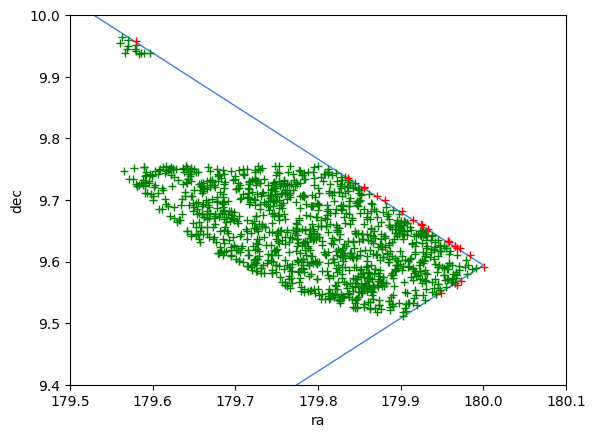

In [29]:
# the healpix pixel to plot
order = 3
pixel = 434

# Plot the points from the specified ztf pixel in green, and from the pixel's margin cache in red
plot_points([ztf_object.get_partition(order, pixel).compute(), ztf_object.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'], xlim=[179.5, 180.1], ylim=[9.4, 10.0])

## Using the Margin Catalog

Performing operations like cross-matching and joining require a margin to be loaded in the catalog on the right side of the operation. If this right catalog has been loaded with a margin, the function will be carried out accurately using the margin, and by default will throw an error if the margin has not been set. This can be overwritten using the `require_right_margin` parameter, but this may cause inaccurate results!

We can see this trying to perform a crossmatch with gaia

In [32]:
gaia = lsdb.read_hipscat(f"{surveys_path}/gaia")
gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7782220156096217088,int64,string,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

If we perform a crossmatch with gaia on the left and the ztf catalog we loaded with a margin on the right, the function works and we get the result

In [33]:
gaia.crossmatch(ztf_object)

,solution_id_gaia_halfdegree,designation_gaia_halfdegree,source_id_gaia_halfdegree,random_index_gaia_halfdegree,ref_epoch_gaia_halfdegree,ra_gaia_halfdegree,ra_error_gaia_halfdegree,dec_gaia_halfdegree,dec_error_gaia_halfdegree,parallax_gaia_halfdegree,parallax_error_gaia_halfdegree,parallax_over_error_gaia_halfdegree,pm_gaia_halfdegree,pmra_gaia_halfdegree,pmra_error_gaia_halfdegree,pmdec_gaia_halfdegree,pmdec_error_gaia_halfdegree,ra_dec_corr_gaia_halfdegree,ra_parallax_corr_gaia_halfdegree,ra_pmra_corr_gaia_halfdegree,ra_pmdec_corr_gaia_halfdegree,dec_parallax_corr_gaia_halfdegree,dec_pmra_corr_gaia_halfdegree,dec_pmdec_corr_gaia_halfdegree,parallax_pmra_corr_gaia_halfdegree,parallax_pmdec_corr_gaia_halfdegree,pmra_pmdec_corr_gaia_halfdegree,astrometric_n_obs_al_gaia_halfdegree,astrometric_n_obs_ac_gaia_halfdegree,astrometric_n_good_obs_al_gaia_halfdegree,astrometric_n_bad_obs_al_gaia_halfdegree,astrometric_gof_al_gaia_halfdegree,astrometric_chi2_al_gaia_halfdegree,astrometric_excess_noise_gaia_halfdegree,astrometric_excess_noise_sig_gaia_halfdegree,astrometric_params_solved_gaia_halfdegree,astrometric_primary_flag_gaia_halfdegree,nu_eff_used_in_astrometry_gaia_halfdegree,pseudocolour_gaia_halfdegree,pseudocolour_error_gaia_halfdegree,ra_pseudocolour_corr_gaia_halfdegree,dec_pseudocolour_corr_gaia_halfdegree,parallax_pseudocolour_corr_gaia_halfdegree,pmra_pseudocolour_corr_gaia_halfdegree,pmdec_pseudocolour_corr_gaia_halfdegree,astrometric_matched_transits_gaia_halfdegree,visibility_periods_used_gaia_halfdegree,astrometric_sigma5d_max_gaia_halfdegree,matched_transits_gaia_halfdegree,new_matched_transits_gaia_halfdegree,matched_transits_removed_gaia_halfdegree,ipd_gof_harmonic_amplitude_gaia_halfdegree,ipd_gof_harmonic_phase_gaia_halfdegree,ipd_frac_multi_peak_gaia_halfdegree,ipd_frac_odd_win_gaia_halfdegree,ruwe_gaia_halfdegree,scan_direction_strength_k1_gaia_halfdegree,scan_direction_strength_k2_gaia_halfdegree,scan_direction_strength_k3_gaia_halfdegree,scan_direction_strength_k4_gaia_halfdegree,scan_direction_mean_k1_gaia_halfdegree,scan_direction_mean_k2_gaia_halfdegree,scan_direction_mean_k3_gaia_halfdegree,scan_direction_mean_k4_gaia_halfdegree,duplicated_source_gaia_halfdegree,phot_g_n_obs_gaia_halfdegree,phot_g_mean_flux_gaia_halfdegree,phot_g_mean_flux_error_gaia_halfdegree,phot_g_mean_flux_over_error_gaia_halfdegree,phot_g_mean_mag_gaia_halfdegree,phot_bp_n_obs_gaia_halfdegree,phot_bp_mean_flux_gaia_halfdegree,phot_bp_mean_flux_error_gaia_halfdegree,phot_bp_mean_flux_over_error_gaia_halfdegree,phot_bp_mean_mag_gaia_halfdegree,phot_rp_n_obs_gaia_halfdegree,phot_rp_mean_flux_gaia_halfdegree,phot_rp_mean_flux_error_gaia_halfdegree,phot_rp_mean_flux_over_error_gaia_halfdegree,phot_rp_mean_mag_gaia_halfdegree,phot_bp_rp_excess_factor_gaia_halfdegree,phot_bp_n_contaminated_transits_gaia_halfdegree,phot_bp_n_blended_transits_gaia_halfdegree,phot_rp_n_contaminated_transits_gaia_halfdegree,phot_rp_n_blended_transits_gaia_halfdegree,phot_proc_mode_gaia_halfdegree,bp_rp_gaia_halfdegree,bp_g_gaia_halfdegree,g_rp_gaia_halfdegree,radial_velocity_gaia_halfdegree,radial_velocity_error_gaia_halfdegree,rv_method_used_gaia_halfdegree,rv_nb_transits_gaia_halfdegree,rv_nb_deblended_transits_gaia_halfdegree,rv_visibility_periods_used_gaia_halfdegree,rv_expected_sig_to_noise_gaia_halfdegree,rv_renormalised_gof_gaia_halfdegree,rv_chisq_pvalue_gaia_halfdegree,rv_time_duration_gaia_halfdegree,rv_amplitude_robust_gaia_halfdegree,rv_template_teff_gaia_halfdegree,rv_template_logg_gaia_halfdegree,rv_template_fe_h_gaia_halfdegree,rv_atm_param_origin_gaia_halfdegree,vbroad_gaia_halfdegree,vbroad_error_gaia_halfdegree,vbroad_nb_transits_gaia_halfdegree,grvs_mag_gaia_halfdegree,grvs_mag_error_gaia_halfdegree,grvs_mag_nb_transits_gaia_halfdegree,rvs_spec_sig_to_noise_gaia_halfdegree,phot_variable_flag_gaia_halfdegree,l_gaia_halfdegree,b_gaia_halfdegree,ecl_lon_gaia_halfdegree,ecl_lat_gaia_halfdegree,in_qso_candidates_gaia_halfdegree,in_galaxy_candid

If we try the other way around, we have not loaded the right catalog (gaia) with a margin cache, and so we get an error

In [35]:
ztf_object.crossmatch(gaia)

ValueError: Right margin is required for cross-match

We can plot the result of the crossmatch below, with the gaia objects in green and the ztf objects in red

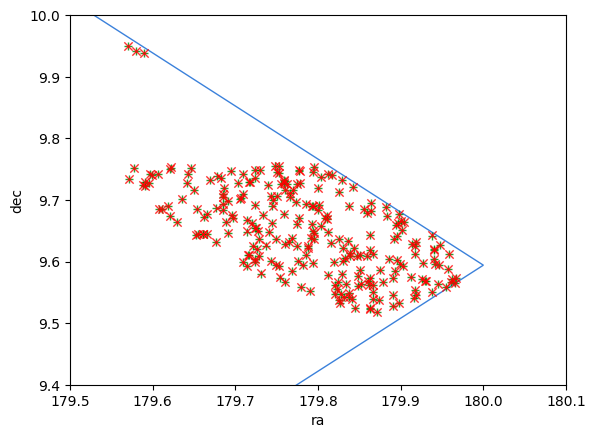

In [47]:
crossmatch_result = gaia.crossmatch(ztf_object)

plot_points([crossmatch_result.get_partition(order, pixel).compute(), crossmatch_result.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra_gaia_halfdegree', 'ra_ztf_object_halfdegree'], ['dec_gaia_halfdegree', 'dec_ztf_object_halfdegree'], xlim=[179.5, 180.1], ylim=[9.4, 10.0], markers=['+', 'x'], alpha=0.8)

## Filtering Catalogs

Any filtering operations applied to the catalog are also performed to the margin.

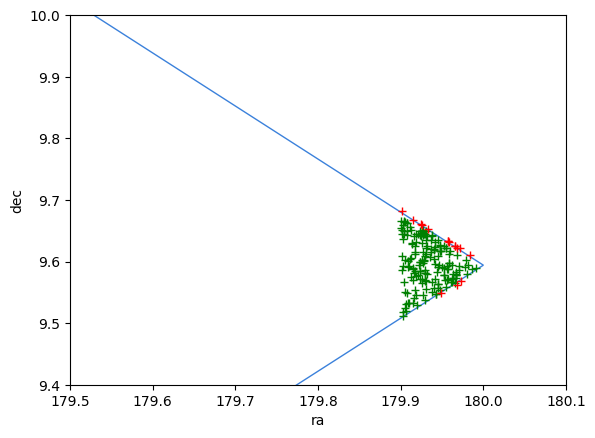

In [48]:
small_sky_box_filter = ztf_object.box(ra=[179.9, 180], dec=[9.5, 9.7])

# Plot the points from the filtered ztf pixel in green, and from the pixel's margin cache in red
plot_points([small_sky_box_filter.get_partition(order, pixel).compute(), small_sky_box_filter.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'], xlim=[179.5, 180.1], ylim=[9.4, 10.0])

## Avoiding Duplicates

Joining the margin cache to the catalog's data would introduce duplicate points, where points near the boundary would appear in the margin of one partition, and the main file of another partition. To avoid this, we keep two separate task graphs, one for the catalog and one for its margin. For operations that don't require the margin, the task graphs are kept separate, and when `compute` is called on the catalog, only the catalog's task graph is computed without joining the margin or even loading the margin files. For operations like crossmatching that require the margin, the task graphs are combined with the margin joined and used. For these operations, we use only the margin for the right side of the catalog. This keeps the results accurate, but since there are no duplicates of the left catalog points, there are no duplicate results.

## Generating a Margin Catalog

If a catalog you are working with doesn't have a margin cache, or you require a margin cache with a different size than has already been generated, a new margin catalog can be generated using `hipscat-import`. First we create a `MarginCacheArguments` object with the parameters of the margin cache we want. 

In [51]:
from hipscat_import.margin_cache.margin_cache_arguments import MarginCacheArguments
import tempfile
import os

tmp_path = str(tempfile.TemporaryDirectory())
output_path = os.path.join(tmp_path, "output")


margin_args = MarginCacheArguments(
    margin_threshold=20,
    input_catalog_path=ztf_object_path,
    output_path=output_path,
    output_artifact_name="ztf_object_margin_20arcsec",
    tmp_dir=tmp_path
)

ValueError: input_catalog_path not a valid catalog